# The Full Report
For academic integrity: this file is created under the guidance of GPT-5

## 准备工作
- imports, 加载文件, 工具函数

In [1]:
import warnings
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
import joblib

DATA_DIR = './'
TRAIN_PATH = os.path.join(DATA_DIR, 'train.csv')
TEST_PATH = os.path.join(DATA_DIR, 'test.csv')
OUT_DIR = DATA_DIR
os.makedirs(OUT_DIR, exist_ok=True)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


In [2]:
df = pd.read_csv(TRAIN_PATH)
print('Shape:', df.shape)
display(df.head())

Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 基础数据可视化

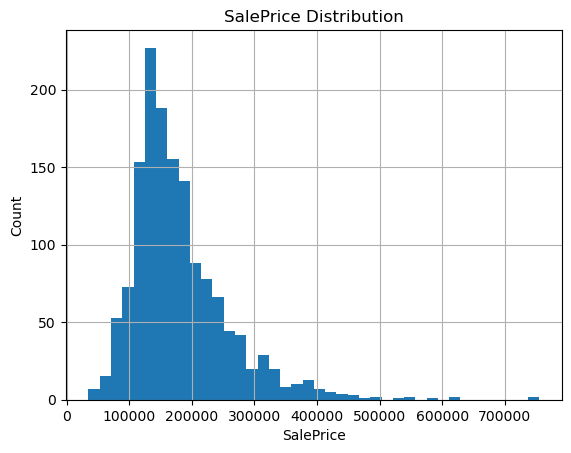

In [3]:
plt.figure()
df['SalePrice'].hist(bins=40)
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

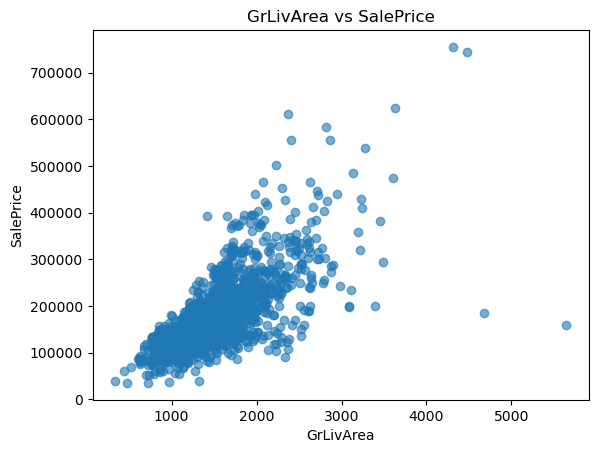

In [4]:
plt.figure()
plt.scatter(df['GrLivArea'], df['SalePrice'], alpha=0.6)
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

<Figure size 640x480 with 0 Axes>

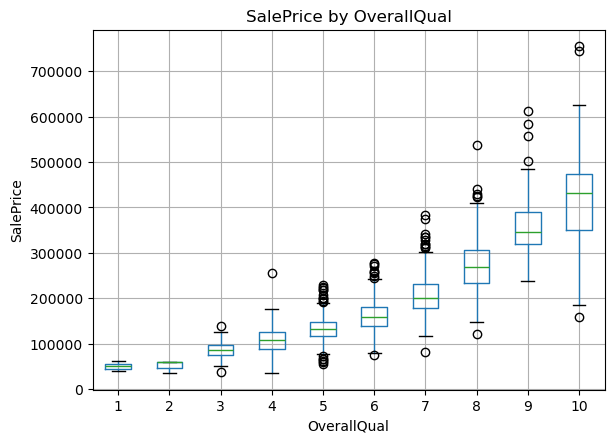

In [5]:
plt.figure()
df[['OverallQual', 'SalePrice']].boxplot(by='OverallQual')
plt.title('SalePrice by OverallQual')
plt.suptitle('')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
display(missing.head(20))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64

## 预处理器
- 数值：`median` 填充 + 标准化
- 类别：众数填充 + One-Hot

In [14]:
y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print('Numerical:', len(num_cols), 'Categorical:', len(cat_cols))

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

Numerical: 37 Categorical: 43


## 多模型效果比较

In [16]:
models = {
    'Ridge(log1p)': TransformedTargetRegressor(
        regressor=Pipeline([('pre', pre), ('reg', Ridge(alpha=5.0, random_state=42))]),
        func=np.log1p, inverse_func=np.expm1
    ),
    'Lasso(log1p)': TransformedTargetRegressor(
        regressor=Pipeline([('pre', pre), ('reg', Lasso(alpha=0.001, max_iter=20000, random_state=42))]),
        func=np.log1p, inverse_func=np.expm1
    ),
    'RandomForest': Pipeline([
        ('pre', pre),
        ('reg', RandomForestRegressor(n_estimators=120, n_jobs=-1, random_state=42))
    ]),
    'HistGB': Pipeline([
        ('pre', pre),
        ('reg', HistGradientBoostingRegressor(learning_rate=0.05, max_iter=200, random_state=42))
    ])
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = {}
for name, model in models.items():
    rmses = []
    for tr, va in kf.split(X, y):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        model.fit(X_tr, y_tr)
        pred = model.predict(X_va)
        rmses.append(rmse(y_va, pred))
    cv_scores[name] = (float(np.mean(rmses)), float(np.std(rmses)))

print('=== CV RMSE (mean ± std), lower is better ===')
for k,(m,s) in cv_scores.items():
    print(f'{k:>16s}: {m:.4f} ± {s:.4f}')

best_name = sorted(cv_scores.items(), key=lambda x: x[1][0])[0][0]
print('\nBest model by CV:', best_name)

=== CV RMSE (mean ± std), lower is better ===
    Ridge(log1p): 57035.7848 ± 44541.7589
    Lasso(log1p): 57152.6730 ± 46860.9378
    RandomForest: 31820.6877 ± 5813.5461
          HistGB: 30090.4316 ± 4676.2722

Best model by CV: HistGB


## 用最佳模型训练

In [28]:
best_model = models[best_name]

oof_pred = np.zeros(len(y))
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for tr, va in kf.split(X, y):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]
    best_model.fit(X_tr, y_tr)
    oof_pred[va] = best_model.predict(X_va)

print('OOF RMSE:', rmse(y, oof_pred))

best_model.fit(X, y)
oof_path = os.path.join(OUT_DIR, 'oof_predictions.csv')
pd.DataFrame({'Id': df['Id'] if 'Id' in df.columns else np.arange(len(df))+1,
              'SalePrice': y,
              'OOF_Pred': oof_pred}).to_csv(oof_path, index=False)
print('Saved OOF to:', oof_path)

model_path = os.path.join(OUT_DIR, 'best_model.joblib')
joblib.dump(best_model, model_path)
print('Saved model to:', model_path)


OOF RMSE: 30455.551916673983
Saved OOF to: ./oof_predictions.csv
Saved model to: ./best_model.joblib
